In [1]:
import numpy as np
import torch as pt
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn import metrics

from config import config_model, config_data
from data_handler import Dataset
from model import Model
from src.dataset import collate_batch_features, select_by_sid, select_by_max_ba, select_by_interface_types
from src.scoring import bc_scoring, bc_score_names

from matplotlib import rcParams
# rcParams['font.family'] = 'sans-serif'
# rcParams['font.sans-serif'] = ['Arial']
# rcParams['font.size'] = 14

In [2]:
def setup_dataset(config_data, r_types_sel):
    # set up dataset
    dataset = Dataset("datasets/contacts_rr4A_64nn.h5")

    # selected structures
    sids_sel = np.genfromtxt("datasets/subunits_validation_highres_set.txt", dtype=np.dtype('U'))

    # filter dataset
    m = select_by_sid(dataset, sids_sel) # select by sids

    # data selection criteria
    m = select_by_sid(dataset, sids_sel) # select by sids
    m &= select_by_max_ba(dataset, config_data['max_ba'])  # select by max assembly count
    #m &= (dataset.sizes[:,0] <= config_data['max_size']) # select by max size
    m &= (dataset.sizes[:,1] >= config_data['min_num_res'])  # select by min size
    m &= select_by_interface_types(dataset, config_data['l_types'], np.concatenate(r_types_sel))  # select by interface type

    # update dataset selection
    dataset.update_mask(m)

    # set dataset types
    dataset.set_types(config_data['l_types'], config_data['r_types'])

    # debug print
    return dataset


In [3]:
def eval_model(model, dataset, ids):
    p_l, y_l = [], []
    with pt.no_grad():
        for i in tqdm(ids):
            # get data
            X, ids_topk, q, M, y = dataset[i]

            # pack data and setup sink (IMPORTANT)
            X, ids_topk, q, M = collate_batch_features([[X, ids_topk, q, M]])

            # run model
            z = model(X.to(device), ids_topk.to(device), q.to(device), M.float().to(device))

            # prediction
            p = pt.sigmoid(z)

            # categorical predictions
            pc = pt.cat([1.0 - pt.max(p, dim=1)[0].unsqueeze(1), p], dim=1).cpu()
            yc = pt.cat([1.0 - pt.any(y > 0.5, dim=1).float().unsqueeze(1), y], dim=1).cpu()

            # data
            p_l.append(pc)
            y_l.append(yc)

    return p_l, y_l

In [4]:
# select saved model
model_filepath = 'model_ckpt.pt'

# define device
device = pt.device("cpu")

# create model
model = Model(config_model)

# reload model
model.load_state_dict(pt.load(model_filepath, map_location=pt.device("cpu")))

# set model to inference
model = model.eval().to(device)

In [5]:
# evaluate model
p_l, y_l = [], []
for i in range(len(config_data['r_types'])):
    # debug print
    print(config_data['r_types'][i])

    # load datasets
    dataset = setup_dataset(config_data, [config_data['r_types'][i]])
    print("dataset: {}".format(len(dataset)))

    # parameters
    N = min(len(dataset), 512)

    # run negative examples
    ids = np.arange(len(dataset))
    np.random.shuffle(ids)
    pi_l, yi_l = eval_model(model, dataset, ids[:N])

    # store evaluation results
    p_l.append(pi_l)
    y_l.append(yi_l)

['NAG', 'BGC', 'GLC', 'MAN', 'GAL', 'FUC', 'BMA', 'BNG', 'XYP', 'UD1', 'A2G', 'UMQ', 'NGA', 'GDU', 'BG6', 'SLB', 'F6R', 'X6X', 'P6F', 'PA1', '1GN']
dataset: 155


100%|██████████| 155/155 [30:12<00:00, 11.69s/it]


['CLY']
dataset: 5


100%|██████████| 5/5 [00:59<00:00, 11.90s/it]


In [6]:
# parameters
class_names = ["carbohydrates", "cyclodextrins"]

# compute scores per class
scores = []
for i in range(len(y_l)):
    # extract class
    p = pt.cat(p_l[i], dim=0)[:,i+1]
    y = pt.cat(y_l[i], dim=0)[:,i+1]

    # compute scores
    s = bc_scoring(y.unsqueeze(1), p.unsqueeze(1)).squeeze().numpy()

    # compute F1 score
    f1 = metrics.f1_score(y.numpy().astype(int), p.numpy().round())

    # compute ratio of positives
    r = pt.mean(y)

    # store results
    scores.append(np.concatenate([s, [f1, r]]))

# pack data
scores = np.stack(scores).T

# make table
df = pd.DataFrame(data=np.round(scores,2), index=bc_score_names+['F1', 'r'], columns=class_names)

# save dataframe
# df.to_csv("results/type_interface_search_scores.csv")

# display
display(df)

,carbohydrates,cyclodextrins
acc,0.92,0.90
ppv,0.36,0.28
npv,0.98,0.98
tpr,0.71,0.65
tnr,0.93,0.91
mcc,0.47,0.38
auc,0.92,0.85
std,0.25,0.24
F1,0.48,0.39
r,0.05,0.05


### Seaching interface

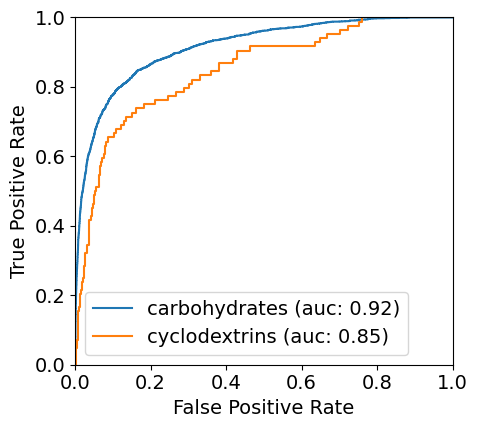

In [7]:
# plot
plt.figure(figsize=(5,4.5))
for i in range(len(y_l)):
    # get labels and predictions for class
    yi = pt.cat(y_l[i], dim=0)[:,i+1]
    pi = pt.cat(p_l[i], dim=0)[:,i+1]

    # compute roc and roc auc
    fpr, tpr, _ = metrics.roc_curve(yi.numpy(), pi.numpy())
    auc = metrics.auc(fpr, tpr)

    # update plot
    plt.plot(fpr, tpr, '-', label="{} (auc: {:.2f})".format(class_names[i], auc))

plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.legend(loc='best')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.tight_layout()
# plt.savefig("results/type_interface_search_roc_auc.svg")
# plt.savefig("results/type_interface_search_roc_auc.png", dpi=300)
plt.show()


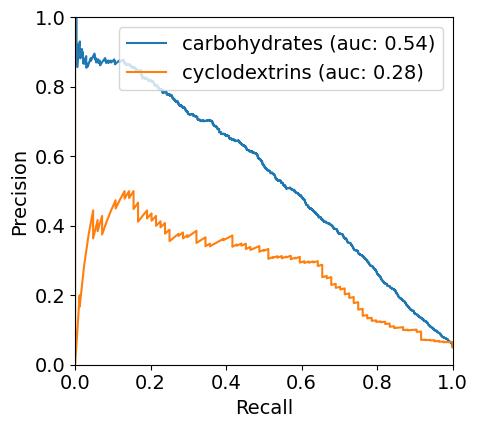

In [8]:
# plot
plt.figure(figsize=(5,4.5))
for i in range(len(y_l)):
    # get labels and predictions for class
    yi = pt.cat(y_l[i], dim=0)[:,i+1]
    pi = pt.cat(p_l[i], dim=0)[:,i+1]

    # compute roc and roc auc
    pre, rec, _ = metrics.precision_recall_curve(yi.numpy(), pi.numpy())
    auc = metrics.auc(rec, pre)

    # update plot
    plt.plot(rec, pre, '-', label="{} (auc: {:.2f})".format(class_names[i], auc))

plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.legend(loc='best')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.tight_layout()
# plt.savefig("results/type_interface_search_pr_auc.svg")
# plt.savefig("results/type_interface_search_pr_auc.png", dpi=300)
plt.show()

In [9]:
# pack results
P = pt.cat([pt.cat(p, dim=0) for p in p_l], dim=0)
Y = pt.cat([pt.cat(y, dim=0) for y in y_l], dim=0)

# select only residues at interface
m = pt.any(Y[:,1:] > 0.5, dim=1)
Pi = P[m,1:]
Yi = Y[m,1:]

# pick same sampling of all classes
n = Yi.shape[1]
N = int(pt.min(pt.sum(Yi, dim=0)).item())
ids_unif = pt.from_numpy(np.concatenate([np.random.choice(pt.where(Yi[:,i] > 0.5)[0].numpy(), N, replace=False) for i in range(n)]))

# compute scores for each class
scores = []
for i in range(n):
    # extract class
    p = Pi[ids_unif,i]
    y = Yi[ids_unif,i]

    # compute scores
    s = bc_scoring(y.unsqueeze(1), p.unsqueeze(1)).squeeze().numpy()

    # compute F1 score
    f1 = metrics.f1_score(y.numpy().astype(int), p.numpy().round())

    scores.append(np.concatenate([s, [f1]]))

# pack data
scores = np.stack(scores).T

# make table
df = pd.DataFrame(data=np.round(scores,2), index=bc_score_names+['F1'], columns=class_names)

# save dataframe
# df.to_csv("results/type_interface_identification_scores.csv")

# display
display(df)


,carbohydrates,cyclodextrins
acc,0.64,0.46
ppv,0.61,0.47
npv,0.71,0.43
tpr,0.81,0.65
tnr,0.48,0.26
mcc,0.30,-0.09
auc,0.68,0.43
std,0.38,0.32
F1,0.69,0.55


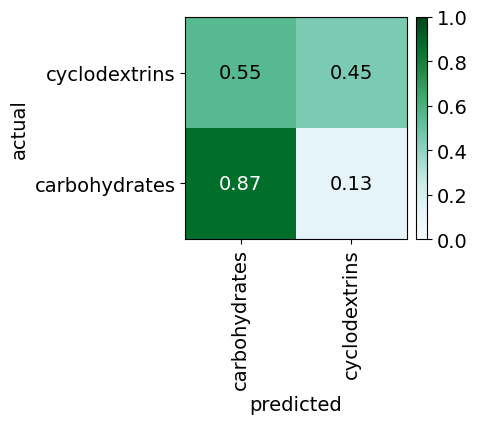

In [10]:
# pack results
P = pt.cat([pt.cat(p, dim=0) for p in p_l], dim=0)
Y = pt.cat([pt.cat(y, dim=0) for y in y_l], dim=0)

# select only residues at interface
m = pt.any(Y[:,1:] > 0.5, dim=1)
Pi = P[m,1:]
Yi = Y[m,1:]

# pick same sampling of all classes
n = Yi.shape[1]
N = int(pt.min(pt.sum(Yi, dim=0)).item())
ids_l = [pt.from_numpy(np.random.choice(pt.where(Yi[:,i] > 0.5)[0].numpy(), N, replace=False)) for i in range(n)]

# compute scores for each class
C = pt.zeros((n,n))
for i in range(n):
    ids = pt.argmax(Pi[ids_l[i]], dim=1)
    for j,k in zip(ids, ids_l[i]):
        C[i,j] += Pi[k,j].round()


# normalize score
H = (C / pt.sum(C, dim=1).unsqueeze(1)).numpy()
#H = (C / pt.sum(C, dim=0).unsqueeze(0)).numpy()

# plot
plt.figure(figsize=(5, 5))
plt.imshow(H, origin='lower', cmap='BuGn', vmin=0.0, vmax=1.0)
plt.colorbar(fraction=0.046, pad=0.04)
plt.xticks(np.arange(n), class_names, rotation=90)
plt.yticks(np.arange(n), class_names)
for i in range(n):
    for j in range(n):
        v = H[i,j]
        if v > 0.1:
            plt.text(j,i,f"{v:.2f}", ha='center', va='center', color=[np.round(v-0.1)]*3)
plt.xlabel('predicted')
plt.ylabel('actual')
plt.tight_layout()
# plt.savefig("results/type_interface_identification_most_confident_confusion_matrix.svg")
# plt.savefig("results/type_interface_identification_most_confident_confusion_matrix.png", dpi=300)
plt.show()

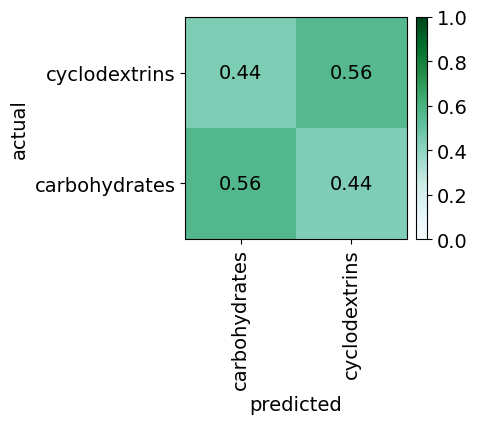

In [11]:
# pack results
P = pt.cat([pt.cat(p, dim=0) for p in p_l], dim=0)
Y = pt.cat([pt.cat(y, dim=0) for y in y_l], dim=0)

# select only residues at interface
m = pt.any(Y[:,1:] > 0.5, dim=1)
Pi = P[m,1:]
Yi = Y[m,1:]

# pick same sampling of all classes
n = Yi.shape[1]
N = int(pt.min(pt.sum(Yi, dim=0)).item())
ids_l = [pt.from_numpy(np.random.choice(pt.where(Yi[:,i] > 0.5)[0].numpy(), N, replace=False)) for i in range(n)]

# compute scores for each class
C = pt.zeros((n,n))
for i in range(n):
    ids = pt.argmax(Pi[ids_l[i]], dim=1)
    for j in range(n):
        for k in ids_l[i]:
            C[i,j] += Pi[k,j].round()


# normalize score
H = (C / pt.sum(C, dim=1).unsqueeze(1)).numpy()
#H = (C / pt.sum(C, dim=0).unsqueeze(0)).numpy()

# plot
plt.figure(figsize=(5, 5))
plt.imshow(H, origin='lower', cmap='BuGn', vmin=0.0, vmax=1.0)
plt.colorbar(fraction=0.046, pad=0.04)
plt.xticks(np.arange(n), class_names, rotation=90)
plt.yticks(np.arange(n), class_names)
for i in range(n):
    for j in range(n):
        v = H[i,j]
        if v > 0.1:
            plt.text(j,i,f"{v:.2f}", ha='center', va='center', color=[np.round(v-0.1)]*3)
plt.xlabel('predicted')
plt.ylabel('actual')
plt.tight_layout()
# plt.savefig("results/type_interface_identification_most_confident_confusion_matrix.svg")
# plt.savefig("results/type_interface_identification_most_confident_confusion_matrix.png", dpi=300)
plt.show()